# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'
Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("CartPole-v0")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-04-29 23:17:11,902] Making new env: CartPole-v0


In [3]:
#plt.imshow(env.render("rgb_array"))
#del env

# Neural Network body

In [4]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 50, nonlinearity=elu)
#nn = DenseLayer(nn, 200, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

[2017-04-29 23:17:13,558] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [6]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-04-29 23:17:18,698] Making new env: CartPole-v0


In [9]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[0 0 1 0 0]]
rewards: [[ 1.  1.  1.  1.  0.]]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.82 ms


In [10]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [11]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [12]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [13]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-3)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [14]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

[2017-04-29 23:10:18,157] Making new env: Acrobot-v1
[2017-04-29 23:10:18,159] Clearing 3 monitor files from previous run (because force=True was provided)
[2017-04-29 23:10:18,381] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')


Episode finished after 500 timesteps with reward=-500.0


In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

[2017-04-29 23:10:19,191] An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



IndexError: list index out of range

# Training loop

In [14]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 300

In [15]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 96/10000 [00:02<03:27, 47.84it/s][2017-04-29 23:17:48,837] Making new env: CartPole-v0
[2017-04-29 23:17:48,839] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:17:48,855] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  1%|          | 106/10000 [00:02<03:35, 45.94it/s]

Episode finished after 9 timesteps with reward=9.0
Episode finished after 19 timesteps with reward=19.0
Episode finished after 20 timesteps with reward=20.0
iter=100	epsilon=0.910
Current score(mean over 3) = 16.000


  2%|▏         | 196/10000 [00:04<03:30, 46.51it/s][2017-04-29 23:17:50,985] Making new env: CartPole-v0
[2017-04-29 23:17:50,987] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:17:51,019] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  2%|▏         | 206/10000 [00:04<03:45, 43.52it/s]

Episode finished after 66 timesteps with reward=66.0
Episode finished after 11 timesteps with reward=11.0
Episode finished after 26 timesteps with reward=26.0
iter=200	epsilon=0.828
Current score(mean over 3) = 34.333


  3%|▎         | 296/10000 [00:06<03:30, 46.19it/s][2017-04-29 23:17:53,187] Making new env: CartPole-v0
[2017-04-29 23:17:53,189] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:17:53,205] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  3%|▎         | 306/10000 [00:06<03:37, 44.53it/s]

Episode finished after 11 timesteps with reward=11.0
Episode finished after 25 timesteps with reward=25.0
Episode finished after 17 timesteps with reward=17.0
iter=300	epsilon=0.754
Current score(mean over 3) = 17.667


  4%|▍         | 396/10000 [00:08<03:52, 41.33it/s][2017-04-29 23:17:55,567] Making new env: CartPole-v0
[2017-04-29 23:17:55,568] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:17:55,590] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  4%|▍         | 406/10000 [00:08<04:02, 39.56it/s]

Episode finished after 38 timesteps with reward=38.0
Episode finished after 19 timesteps with reward=19.0
Episode finished after 13 timesteps with reward=13.0
iter=400	epsilon=0.687
Current score(mean over 3) = 23.333


  5%|▍         | 496/10000 [00:11<03:54, 40.54it/s][2017-04-29 23:17:58,043] Making new env: CartPole-v0
[2017-04-29 23:17:58,045] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:17:58,074] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  5%|▌         | 506/10000 [00:11<04:06, 38.52it/s]

Episode finished after 32 timesteps with reward=32.0
Episode finished after 44 timesteps with reward=44.0
Episode finished after 19 timesteps with reward=19.0
iter=500	epsilon=0.626
Current score(mean over 3) = 31.667


  6%|▌         | 598/10000 [00:13<03:54, 40.07it/s][2017-04-29 23:18:00,567] Making new env: CartPole-v0
[2017-04-29 23:18:00,569] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:00,605] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  6%|▌         | 603/10000 [00:13<04:16, 36.64it/s]

Episode finished after 22 timesteps with reward=22.0
Episode finished after 24 timesteps with reward=24.0
Episode finished after 76 timesteps with reward=76.0
iter=600	epsilon=0.571
Current score(mean over 3) = 40.667


  7%|▋         | 696/10000 [00:16<03:55, 39.53it/s][2017-04-29 23:18:03,127] Making new env: CartPole-v0
[2017-04-29 23:18:03,129] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:03,187] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  7%|▋         | 704/10000 [00:16<04:25, 34.95it/s]

Episode finished after 64 timesteps with reward=64.0
Episode finished after 67 timesteps with reward=67.0
Episode finished after 66 timesteps with reward=66.0
iter=700	epsilon=0.522
Current score(mean over 3) = 65.667


  8%|▊         | 796/10000 [00:18<03:58, 38.66it/s][2017-04-29 23:18:05,762] Making new env: CartPole-v0
[2017-04-29 23:18:05,763] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:05,798] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  8%|▊         | 804/10000 [00:19<04:15, 36.00it/s]

Episode finished after 41 timesteps with reward=41.0
Episode finished after 40 timesteps with reward=40.0
Episode finished after 32 timesteps with reward=32.0
iter=800	epsilon=0.477
Current score(mean over 3) = 37.667


  9%|▉         | 896/10000 [00:21<03:56, 38.48it/s][2017-04-29 23:18:08,389] Making new env: CartPole-v0
[2017-04-29 23:18:08,391] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:08,415] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
  9%|▉         | 904/10000 [00:21<04:10, 36.38it/s]

Episode finished after 35 timesteps with reward=35.0
Episode finished after 9 timesteps with reward=9.0
Episode finished after 35 timesteps with reward=35.0
iter=900	epsilon=0.436
Current score(mean over 3) = 26.333


 10%|▉         | 996/10000 [00:24<03:57, 37.90it/s][2017-04-29 23:18:11,043] Making new env: CartPole-v0
[2017-04-29 23:18:11,045] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:11,076] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 10%|█         | 1004/10000 [00:24<04:13, 35.51it/s]

Episode finished after 24 timesteps with reward=24.0
Episode finished after 33 timesteps with reward=33.0
Episode finished after 46 timesteps with reward=46.0
iter=1000	epsilon=0.399
Current score(mean over 3) = 34.333


 11%|█         | 1096/10000 [00:26<03:57, 37.45it/s][2017-04-29 23:18:13,737] Making new env: CartPole-v0
[2017-04-29 23:18:13,738] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:13,781] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 11%|█         | 1104/10000 [00:27<04:18, 34.35it/s]

Episode finished after 62 timesteps with reward=62.0
Episode finished after 34 timesteps with reward=34.0
Episode finished after 47 timesteps with reward=47.0
iter=1100	epsilon=0.366
Current score(mean over 3) = 47.667


 12%|█▏        | 1196/10000 [00:29<03:58, 36.91it/s][2017-04-29 23:18:16,485] Making new env: CartPole-v0
[2017-04-29 23:18:16,487] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:16,524] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 12%|█▏        | 1204/10000 [00:29<04:17, 34.15it/s]

Episode finished after 34 timesteps with reward=34.0
Episode finished after 46 timesteps with reward=46.0
Episode finished after 43 timesteps with reward=43.0
iter=1200	epsilon=0.336
Current score(mean over 3) = 41.000


 13%|█▎        | 1296/10000 [00:32<04:00, 36.21it/s][2017-04-29 23:18:19,276] Making new env: CartPole-v0
[2017-04-29 23:18:19,278] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:19,329] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 13%|█▎        | 1304/10000 [00:32<04:25, 32.78it/s]

Episode finished after 44 timesteps with reward=44.0
Episode finished after 91 timesteps with reward=91.0
Episode finished after 39 timesteps with reward=39.0
iter=1300	epsilon=0.309
Current score(mean over 3) = 58.000


 14%|█▍        | 1397/10000 [00:34<03:24, 42.02it/s][2017-04-29 23:18:21,743] Making new env: CartPole-v0
[2017-04-29 23:18:21,745] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:21,792] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 14%|█▍        | 1402/10000 [00:35<03:49, 37.40it/s]

Episode finished after 41 timesteps with reward=41.0
Episode finished after 50 timesteps with reward=50.0
Episode finished after 66 timesteps with reward=66.0
iter=1400	epsilon=0.284
Current score(mean over 3) = 52.333


 15%|█▍        | 1497/10000 [00:37<03:25, 41.29it/s][2017-04-29 23:18:24,200] Making new env: CartPole-v0
[2017-04-29 23:18:24,202] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:24,269] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 15%|█▌        | 1502/10000 [00:37<04:01, 35.22it/s]

Episode finished after 50 timesteps with reward=50.0
Episode finished after 113 timesteps with reward=113.0
Episode finished after 64 timesteps with reward=64.0
iter=1500	epsilon=0.262
Current score(mean over 3) = 75.667


 16%|█▌        | 1597/10000 [00:39<03:27, 40.51it/s][2017-04-29 23:18:26,730] Making new env: CartPole-v0
[2017-04-29 23:18:26,731] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:26,802] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 16%|█▌        | 1602/10000 [00:40<04:04, 34.41it/s]

Episode finished after 103 timesteps with reward=103.0
Episode finished after 67 timesteps with reward=67.0
Episode finished after 69 timesteps with reward=69.0
iter=1600	epsilon=0.242
Current score(mean over 3) = 79.667


 17%|█▋        | 1697/10000 [00:42<03:28, 39.80it/s][2017-04-29 23:18:29,304] Making new env: CartPole-v0
[2017-04-29 23:18:29,306] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:29,399] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 17%|█▋        | 1705/10000 [00:42<04:10, 33.09it/s]

Episode finished after 131 timesteps with reward=131.0
Episode finished after 84 timesteps with reward=84.0
Episode finished after 100 timesteps with reward=100.0
iter=1700	epsilon=0.224
Current score(mean over 3) = 105.000


 18%|█▊        | 1797/10000 [00:45<03:28, 39.25it/s][2017-04-29 23:18:31,933] Making new env: CartPole-v0
[2017-04-29 23:18:31,934] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:32,028] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 18%|█▊        | 1805/10000 [00:45<04:10, 32.66it/s]

Episode finished after 89 timesteps with reward=89.0
Episode finished after 112 timesteps with reward=112.0
Episode finished after 114 timesteps with reward=114.0
iter=1800	epsilon=0.207
Current score(mean over 3) = 105.000


 19%|█▉        | 1897/10000 [00:47<03:30, 38.56it/s][2017-04-29 23:18:34,606] Making new env: CartPole-v0
[2017-04-29 23:18:34,608] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:34,717] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 19%|█▉        | 1905/10000 [00:48<04:17, 31.50it/s]

Episode finished after 137 timesteps with reward=137.0
Episode finished after 114 timesteps with reward=114.0
Episode finished after 120 timesteps with reward=120.0
iter=1900	epsilon=0.192
Current score(mean over 3) = 123.667


 20%|█▉        | 1997/10000 [00:50<03:28, 38.38it/s][2017-04-29 23:18:37,315] Making new env: CartPole-v0
[2017-04-29 23:18:37,317] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:37,434] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 20%|██        | 2001/10000 [00:50<04:39, 28.61it/s]

Episode finished after 106 timesteps with reward=106.0
Episode finished after 122 timesteps with reward=122.0
Episode finished after 168 timesteps with reward=168.0
iter=2000	epsilon=0.179
Current score(mean over 3) = 132.000


 21%|██        | 2098/10000 [00:53<03:16, 40.26it/s][2017-04-29 23:18:39,923] Making new env: CartPole-v0
[2017-04-29 23:18:39,924] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:40,048] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 21%|██        | 2103/10000 [00:53<04:16, 30.81it/s]

Episode finished after 152 timesteps with reward=152.0
Episode finished after 127 timesteps with reward=127.0
Episode finished after 147 timesteps with reward=147.0
iter=2100	epsilon=0.166
Current score(mean over 3) = 142.000


 22%|██▏       | 2199/10000 [00:55<03:13, 40.24it/s][2017-04-29 23:18:42,540] Making new env: CartPole-v0
[2017-04-29 23:18:42,541] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:42,674] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 22%|██▏       | 2204/10000 [00:56<04:17, 30.27it/s]

Episode finished after 162 timesteps with reward=162.0
Episode finished after 156 timesteps with reward=156.0
Episode finished after 139 timesteps with reward=139.0
iter=2200	epsilon=0.155
Current score(mean over 3) = 152.333


 23%|██▎       | 2298/10000 [00:58<03:11, 40.12it/s][2017-04-29 23:18:45,166] Making new env: CartPole-v0
[2017-04-29 23:18:45,168] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:45,293] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 23%|██▎       | 2303/10000 [00:58<04:10, 30.69it/s]

Episode finished after 175 timesteps with reward=175.0
Episode finished after 133 timesteps with reward=133.0
Episode finished after 122 timesteps with reward=122.0
iter=2300	epsilon=0.145
Current score(mean over 3) = 143.333


 24%|██▍       | 2396/10000 [01:00<03:09, 40.19it/s][2017-04-29 23:18:47,784] Making new env: CartPole-v0
[2017-04-29 23:18:47,786] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:47,911] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 24%|██▍       | 2401/10000 [01:01<04:07, 30.71it/s]

Episode finished after 133 timesteps with reward=133.0
Episode finished after 158 timesteps with reward=158.0
Episode finished after 142 timesteps with reward=142.0
iter=2400	epsilon=0.136
Current score(mean over 3) = 144.333


 25%|██▍       | 2496/10000 [01:03<03:06, 40.14it/s][2017-04-29 23:18:50,406] Making new env: CartPole-v0
[2017-04-29 23:18:50,408] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:50,565] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 25%|██▌       | 2501/10000 [01:03<04:18, 28.98it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 192 timesteps with reward=192.0
Episode finished after 154 timesteps with reward=154.0
iter=2500	epsilon=0.128
Current score(mean over 3) = 182.000


 26%|██▌       | 2595/10000 [01:06<03:04, 40.17it/s][2017-04-29 23:18:53,059] Making new env: CartPole-v0
[2017-04-29 23:18:53,061] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:53,216] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 26%|██▌       | 2604/10000 [01:06<03:53, 31.62it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 154 timesteps with reward=154.0
Episode finished after 183 timesteps with reward=183.0
iter=2600	epsilon=0.121
Current score(mean over 3) = 179.000


 27%|██▋       | 2697/10000 [01:08<03:03, 39.89it/s][2017-04-29 23:18:55,726] Making new env: CartPole-v0
[2017-04-29 23:18:55,728] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:55,890] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 27%|██▋       | 2701/10000 [01:09<04:32, 26.75it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 154 timesteps with reward=154.0
iter=2700	epsilon=0.114
Current score(mean over 3) = 184.667


 28%|██▊       | 2796/10000 [01:11<03:00, 39.82it/s][2017-04-29 23:18:58,403] Making new env: CartPole-v0
[2017-04-29 23:18:58,404] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:18:58,580] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 28%|██▊       | 2800/10000 [01:11<04:36, 26.05it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=2800	epsilon=0.108
Current score(mean over 3) = 200.000


 29%|██▉       | 2899/10000 [01:14<02:57, 39.99it/s][2017-04-29 23:19:01,088] Making new env: CartPole-v0
[2017-04-29 23:19:01,090] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:01,262] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 29%|██▉       | 2903/10000 [01:14<04:30, 26.21it/s]

Episode finished after 191 timesteps with reward=191.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=2900	epsilon=0.102
Current score(mean over 3) = 197.000


 30%|██▉       | 2997/10000 [01:16<02:56, 39.71it/s][2017-04-29 23:19:03,773] Making new env: CartPole-v0
[2017-04-29 23:19:03,774] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:03,953] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 30%|███       | 3001/10000 [01:17<04:31, 25.82it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=3000	epsilon=0.097
Current score(mean over 3) = 200.000


 31%|███       | 3096/10000 [01:19<02:53, 39.76it/s][2017-04-29 23:19:06,463] Making new env: CartPole-v0
[2017-04-29 23:19:06,465] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:06,640] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 31%|███       | 3100/10000 [01:19<04:24, 26.05it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=3100	epsilon=0.093
Current score(mean over 3) = 200.000


 32%|███▏      | 3195/10000 [01:22<02:51, 39.70it/s][2017-04-29 23:19:09,153] Making new env: CartPole-v0
[2017-04-29 23:19:09,154] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:09,323] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 32%|███▏      | 3200/10000 [01:22<04:00, 28.27it/s]

Episode finished after 176 timesteps with reward=176.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=3200	epsilon=0.089
Current score(mean over 3) = 192.000


 33%|███▎      | 3298/10000 [01:25<02:48, 39.71it/s][2017-04-29 23:19:11,842] Making new env: CartPole-v0
[2017-04-29 23:19:11,843] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:12,017] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 33%|███▎      | 3302/10000 [01:25<04:16, 26.07it/s]

Episode finished after 192 timesteps with reward=192.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=3300	epsilon=0.085
Current score(mean over 3) = 197.333


 34%|███▍      | 3399/10000 [01:27<02:45, 39.85it/s][2017-04-29 23:19:14,528] Making new env: CartPole-v0
[2017-04-29 23:19:14,530] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:14,696] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 34%|███▍      | 3403/10000 [01:28<04:09, 26.49it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 199 timesteps with reward=199.0
Episode finished after 170 timesteps with reward=170.0
iter=3400	epsilon=0.082
Current score(mean over 3) = 189.667


 35%|███▍      | 3497/10000 [01:30<02:43, 39.87it/s][2017-04-29 23:19:17,210] Making new env: CartPole-v0
[2017-04-29 23:19:17,212] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:17,386] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 35%|███▌      | 3501/10000 [01:30<04:08, 26.11it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=3500	epsilon=0.079
Current score(mean over 3) = 200.000


 36%|███▌      | 3599/10000 [01:33<02:40, 39.92it/s][2017-04-29 23:19:19,894] Making new env: CartPole-v0
[2017-04-29 23:19:19,896] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:20,071] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 36%|███▌      | 3603/10000 [01:33<04:06, 25.98it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 197 timesteps with reward=197.0
iter=3600	epsilon=0.076
Current score(mean over 3) = 199.000


 37%|███▋      | 3699/10000 [01:35<02:38, 39.74it/s][2017-04-29 23:19:22,584] Making new env: CartPole-v0
[2017-04-29 23:19:22,586] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:22,724] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 37%|███▋      | 3703/10000 [01:36<03:45, 27.91it/s]

Episode finished after 151 timesteps with reward=151.0
Episode finished after 152 timesteps with reward=152.0
Episode finished after 169 timesteps with reward=169.0
iter=3700	epsilon=0.073
Current score(mean over 3) = 157.333


 38%|███▊      | 3796/10000 [01:38<02:35, 39.86it/s][2017-04-29 23:19:25,235] Making new env: CartPole-v0
[2017-04-29 23:19:25,237] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:25,397] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 38%|███▊      | 3800/10000 [01:38<03:50, 26.85it/s]

Episode finished after 184 timesteps with reward=184.0
Episode finished after 189 timesteps with reward=189.0
Episode finished after 173 timesteps with reward=173.0
iter=3800	epsilon=0.071
Current score(mean over 3) = 182.000


 39%|███▉      | 3896/10000 [01:41<02:33, 39.75it/s][2017-04-29 23:19:27,907] Making new env: CartPole-v0
[2017-04-29 23:19:27,909] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:28,085] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 39%|███▉      | 3900/10000 [01:41<03:54, 26.01it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 194 timesteps with reward=194.0
iter=3900	epsilon=0.069
Current score(mean over 3) = 198.000


 40%|███▉      | 3996/10000 [01:43<02:29, 40.19it/s][2017-04-29 23:19:30,578] Making new env: CartPole-v0
[2017-04-29 23:19:30,579] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:30,751] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 40%|████      | 4001/10000 [01:44<03:32, 28.27it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 192 timesteps with reward=192.0
Episode finished after 200 timesteps with reward=200.0
iter=4000	epsilon=0.067
Current score(mean over 3) = 197.333


 41%|████      | 4098/10000 [01:46<02:28, 39.82it/s][2017-04-29 23:19:33,245] Making new env: CartPole-v0
[2017-04-29 23:19:33,247] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:33,423] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 41%|████      | 4102/10000 [01:46<03:46, 26.02it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=4100	epsilon=0.066
Current score(mean over 3) = 200.000


 42%|████▏     | 4198/10000 [01:49<02:24, 40.03it/s][2017-04-29 23:19:35,917] Making new env: CartPole-v0
[2017-04-29 23:19:35,919] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:36,092] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 42%|████▏     | 4203/10000 [01:49<03:25, 28.15it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 199 timesteps with reward=199.0
iter=4200	epsilon=0.064
Current score(mean over 3) = 199.667


 43%|████▎     | 4297/10000 [01:51<02:22, 40.13it/s][2017-04-29 23:19:38,581] Making new env: CartPole-v0
[2017-04-29 23:19:38,583] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:38,754] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 43%|████▎     | 4302/10000 [01:52<03:21, 28.26it/s]

Episode finished after 194 timesteps with reward=194.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=4300	epsilon=0.063
Current score(mean over 3) = 198.000


 44%|████▍     | 4395/10000 [01:54<02:20, 39.83it/s][2017-04-29 23:19:41,268] Making new env: CartPole-v0
[2017-04-29 23:19:41,270] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:41,428] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 44%|████▍     | 4400/10000 [01:54<03:14, 28.85it/s]

Episode finished after 152 timesteps with reward=152.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 192 timesteps with reward=192.0
iter=4400	epsilon=0.062
Current score(mean over 3) = 181.333


 45%|████▍     | 4495/10000 [01:57<02:18, 39.88it/s][2017-04-29 23:19:43,938] Making new env: CartPole-v0
[2017-04-29 23:19:43,939] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:44,112] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 45%|████▌     | 4500/10000 [01:57<03:15, 28.15it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 193 timesteps with reward=193.0
Episode finished after 200 timesteps with reward=200.0
iter=4500	epsilon=0.061
Current score(mean over 3) = 197.667


 46%|████▌     | 4596/10000 [01:59<02:15, 40.00it/s][2017-04-29 23:19:46,609] Making new env: CartPole-v0
[2017-04-29 23:19:46,611] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:46,784] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 46%|████▌     | 4601/10000 [02:00<03:11, 28.16it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=4600	epsilon=0.060
Current score(mean over 3) = 200.000


 47%|████▋     | 4696/10000 [02:02<02:12, 39.97it/s][2017-04-29 23:19:49,296] Making new env: CartPole-v0
[2017-04-29 23:19:49,297] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:49,468] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 47%|████▋     | 4700/10000 [02:02<03:21, 26.31it/s]

Episode finished after 181 timesteps with reward=181.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=4700	epsilon=0.059
Current score(mean over 3) = 193.667


 48%|████▊     | 4797/10000 [02:05<02:09, 40.02it/s][2017-04-29 23:19:51,975] Making new env: CartPole-v0
[2017-04-29 23:19:51,976] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:52,149] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 48%|████▊     | 4802/10000 [02:05<03:04, 28.11it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 196 timesteps with reward=196.0
Episode finished after 200 timesteps with reward=200.0
iter=4800	epsilon=0.058
Current score(mean over 3) = 198.667


 49%|████▉     | 4898/10000 [02:07<02:07, 40.12it/s][2017-04-29 23:19:54,644] Making new env: CartPole-v0
[2017-04-29 23:19:54,645] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:54,821] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 49%|████▉     | 4903/10000 [02:08<03:01, 28.08it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 199 timesteps with reward=199.0
iter=4900	epsilon=0.057
Current score(mean over 3) = 199.667


 50%|████▉     | 4995/10000 [02:10<02:04, 40.16it/s][2017-04-29 23:19:57,312] Making new env: CartPole-v0
[2017-04-29 23:19:57,313] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:19:57,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 50%|█████     | 5000/10000 [02:10<02:57, 28.18it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=5000	epsilon=0.056
Current score(mean over 3) = 200.000


 51%|█████     | 5096/10000 [02:13<02:02, 39.99it/s][2017-04-29 23:19:59,986] Making new env: CartPole-v0
[2017-04-29 23:19:59,988] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:00,163] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 51%|█████     | 5101/10000 [02:13<02:54, 28.01it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=5100	epsilon=0.056
Current score(mean over 3) = 200.000


 52%|█████▏    | 5199/10000 [02:15<02:00, 39.74it/s][2017-04-29 23:20:02,677] Making new env: CartPole-v0
[2017-04-29 23:20:02,679] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:02,854] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 52%|█████▏    | 5203/10000 [02:16<03:04, 26.00it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=5200	epsilon=0.055
Current score(mean over 3) = 200.000


 53%|█████▎    | 5299/10000 [02:18<01:58, 39.74it/s][2017-04-29 23:20:05,372] Making new env: CartPole-v0
[2017-04-29 23:20:05,373] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:05,549] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 53%|█████▎    | 5303/10000 [02:18<03:00, 25.98it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=5300	epsilon=0.055
Current score(mean over 3) = 200.000


 54%|█████▍    | 5397/10000 [02:21<01:55, 39.82it/s][2017-04-29 23:20:08,060] Making new env: CartPole-v0
[2017-04-29 23:20:08,061] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:08,235] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 54%|█████▍    | 5401/10000 [02:21<02:56, 26.06it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=5400	epsilon=0.054
Current score(mean over 3) = 200.000


 55%|█████▍    | 5497/10000 [02:23<01:52, 40.13it/s][2017-04-29 23:20:10,730] Making new env: CartPole-v0
[2017-04-29 23:20:10,731] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:10,903] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 55%|█████▌    | 5502/10000 [02:24<02:39, 28.22it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 197 timesteps with reward=197.0
Episode finished after 196 timesteps with reward=196.0
iter=5500	epsilon=0.054
Current score(mean over 3) = 197.667


 56%|█████▌    | 5599/10000 [02:26<01:49, 40.20it/s][2017-04-29 23:20:13,397] Making new env: CartPole-v0
[2017-04-29 23:20:13,399] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:13,572] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')


Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=5600	epsilon=0.054
Current score(mean over 3) = 200.000


 57%|█████▋    | 5698/10000 [02:29<01:47, 40.17it/s][2017-04-29 23:20:16,062] Making new env: CartPole-v0
[2017-04-29 23:20:16,064] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:16,207] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 57%|█████▋    | 5703/10000 [02:29<02:24, 29.67it/s]

Episode finished after 198 timesteps with reward=198.0
Episode finished after 104 timesteps with reward=104.0
Episode finished after 195 timesteps with reward=195.0
iter=5700	epsilon=0.053
Current score(mean over 3) = 165.667


 58%|█████▊    | 5797/10000 [02:31<01:44, 40.25it/s][2017-04-29 23:20:18,695] Making new env: CartPole-v0
[2017-04-29 23:20:18,696] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:18,842] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 58%|█████▊    | 5802/10000 [02:32<02:21, 29.68it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 102 timesteps with reward=102.0
iter=5800	epsilon=0.053
Current score(mean over 3) = 167.333


 59%|█████▉    | 5899/10000 [02:34<01:42, 40.17it/s][2017-04-29 23:20:21,331] Making new env: CartPole-v0
[2017-04-29 23:20:21,332] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:21,483] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 59%|█████▉    | 5904/10000 [02:34<02:19, 29.28it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 123 timesteps with reward=123.0
Episode finished after 200 timesteps with reward=200.0
iter=5900	epsilon=0.053
Current score(mean over 3) = 174.333


 60%|█████▉    | 5998/10000 [02:37<01:40, 39.82it/s][2017-04-29 23:20:23,992] Making new env: CartPole-v0
[2017-04-29 23:20:23,994] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:24,169] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 60%|██████    | 6002/10000 [02:37<02:33, 26.02it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=6000	epsilon=0.052
Current score(mean over 3) = 200.000


 61%|██████    | 6096/10000 [02:39<01:37, 39.86it/s][2017-04-29 23:20:26,680] Making new env: CartPole-v0
[2017-04-29 23:20:26,681] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:26,840] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 61%|██████    | 6100/10000 [02:40<02:24, 26.94it/s]

Episode finished after 156 timesteps with reward=156.0
Episode finished after 187 timesteps with reward=187.0
Episode finished after 200 timesteps with reward=200.0
iter=6100	epsilon=0.052
Current score(mean over 3) = 181.000


 62%|██████▏   | 6197/10000 [02:42<01:35, 39.86it/s][2017-04-29 23:20:29,350] Making new env: CartPole-v0
[2017-04-29 23:20:29,351] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:29,526] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 62%|██████▏   | 6201/10000 [02:42<02:26, 26.02it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=6200	epsilon=0.052
Current score(mean over 3) = 200.000


 63%|██████▎   | 6297/10000 [02:45<01:33, 39.80it/s][2017-04-29 23:20:32,044] Making new env: CartPole-v0
[2017-04-29 23:20:32,045] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:32,186] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 63%|██████▎   | 6301/10000 [02:45<02:12, 27.88it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 112 timesteps with reward=112.0
Episode finished after 169 timesteps with reward=169.0
iter=6300	epsilon=0.052
Current score(mean over 3) = 160.333


 64%|██████▍   | 6398/10000 [02:47<01:30, 39.79it/s][2017-04-29 23:20:34,696] Making new env: CartPole-v0
[2017-04-29 23:20:34,697] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:34,843] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 64%|██████▍   | 6402/10000 [02:48<02:10, 27.65it/s]

Episode finished after 172 timesteps with reward=172.0
Episode finished after 121 timesteps with reward=121.0
Episode finished after 200 timesteps with reward=200.0
iter=6400	epsilon=0.052
Current score(mean over 3) = 164.333


 65%|██████▍   | 6498/10000 [02:50<01:27, 39.86it/s][2017-04-29 23:20:37,359] Making new env: CartPole-v0
[2017-04-29 23:20:37,361] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:37,534] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 65%|██████▌   | 6502/10000 [02:50<02:14, 26.10it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 190 timesteps with reward=190.0
Episode finished after 200 timesteps with reward=200.0
iter=6500	epsilon=0.051
Current score(mean over 3) = 196.667


 66%|██████▌   | 6597/10000 [02:53<01:25, 39.75it/s][2017-04-29 23:20:40,047] Making new env: CartPole-v0
[2017-04-29 23:20:40,048] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:40,197] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 66%|██████▌   | 6601/10000 [02:53<02:04, 27.37it/s]

Episode finished after 174 timesteps with reward=174.0
Episode finished after 155 timesteps with reward=155.0
Episode finished after 181 timesteps with reward=181.0
iter=6600	epsilon=0.051
Current score(mean over 3) = 170.000


 67%|██████▋   | 6699/10000 [02:55<01:21, 40.27it/s][2017-04-29 23:20:42,684] Making new env: CartPole-v0
[2017-04-29 23:20:42,686] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:42,796] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 67%|██████▋   | 6704/10000 [02:56<01:44, 31.61it/s]

Episode finished after 102 timesteps with reward=102.0
Episode finished after 165 timesteps with reward=165.0
Episode finished after 110 timesteps with reward=110.0
iter=6700	epsilon=0.051
Current score(mean over 3) = 125.667


 68%|██████▊   | 6796/10000 [02:58<01:19, 40.23it/s][2017-04-29 23:20:45,286] Making new env: CartPole-v0
[2017-04-29 23:20:45,288] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:45,440] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 68%|██████▊   | 6801/10000 [02:58<01:49, 29.31it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 169 timesteps with reward=169.0
Episode finished after 153 timesteps with reward=153.0
iter=6800	epsilon=0.051
Current score(mean over 3) = 174.000


 69%|██████▉   | 6899/10000 [03:01<01:16, 40.28it/s][2017-04-29 23:20:47,926] Making new env: CartPole-v0
[2017-04-29 23:20:47,928] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:48,102] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')


Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=6900	epsilon=0.051
Current score(mean over 3) = 200.000


 70%|██████▉   | 6999/10000 [03:03<01:15, 39.89it/s][2017-04-29 23:20:50,613] Making new env: CartPole-v0
[2017-04-29 23:20:50,615] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:50,762] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 70%|███████   | 7003/10000 [03:04<01:49, 27.46it/s]

Episode finished after 168 timesteps with reward=168.0
Episode finished after 171 timesteps with reward=171.0
Episode finished after 167 timesteps with reward=167.0
iter=7000	epsilon=0.051
Current score(mean over 3) = 168.667


 71%|███████   | 7096/10000 [03:06<01:12, 39.94it/s][2017-04-29 23:20:53,270] Making new env: CartPole-v0
[2017-04-29 23:20:53,272] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:53,423] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 71%|███████   | 7104/10000 [03:06<01:35, 30.17it/s]

Episode finished after 184 timesteps with reward=184.0
Episode finished after 171 timesteps with reward=171.0
Episode finished after 167 timesteps with reward=167.0
iter=7100	epsilon=0.051
Current score(mean over 3) = 174.000


 72%|███████▏  | 7198/10000 [03:09<01:10, 39.83it/s][2017-04-29 23:20:55,938] Making new env: CartPole-v0
[2017-04-29 23:20:55,940] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:56,093] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 72%|███████▏  | 7202/10000 [03:09<01:42, 27.18it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 153 timesteps with reward=153.0
Episode finished after 172 timesteps with reward=172.0
iter=7200	epsilon=0.051
Current score(mean over 3) = 175.000


 73%|███████▎  | 7297/10000 [03:11<01:07, 39.91it/s][2017-04-29 23:20:58,603] Making new env: CartPole-v0
[2017-04-29 23:20:58,604] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:20:58,728] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 73%|███████▎  | 7301/10000 [03:12<01:33, 29.01it/s]

Episode finished after 152 timesteps with reward=152.0
Episode finished after 115 timesteps with reward=115.0
Episode finished after 155 timesteps with reward=155.0
iter=7300	epsilon=0.051
Current score(mean over 3) = 140.667


 74%|███████▍  | 7399/10000 [03:14<01:05, 39.95it/s][2017-04-29 23:21:01,237] Making new env: CartPole-v0
[2017-04-29 23:21:01,239] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:01,375] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 74%|███████▍  | 7403/10000 [03:14<01:32, 28.22it/s]

Episode finished after 154 timesteps with reward=154.0
Episode finished after 158 timesteps with reward=158.0
Episode finished after 151 timesteps with reward=151.0
iter=7400	epsilon=0.051
Current score(mean over 3) = 154.333


 75%|███████▍  | 7497/10000 [03:17<01:02, 39.86it/s][2017-04-29 23:21:03,884] Making new env: CartPole-v0
[2017-04-29 23:21:03,886] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:04,030] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 75%|███████▌  | 7501/10000 [03:17<01:30, 27.71it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 148 timesteps with reward=148.0
Episode finished after 150 timesteps with reward=150.0
iter=7500	epsilon=0.051
Current score(mean over 3) = 166.000


 76%|███████▌  | 7598/10000 [03:19<01:00, 39.67it/s][2017-04-29 23:21:06,552] Making new env: CartPole-v0
[2017-04-29 23:21:06,554] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:06,701] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 76%|███████▌  | 7602/10000 [03:20<01:27, 27.43it/s]

Episode finished after 166 timesteps with reward=166.0
Episode finished after 198 timesteps with reward=198.0
Episode finished after 143 timesteps with reward=143.0
iter=7600	epsilon=0.050
Current score(mean over 3) = 169.000


 77%|███████▋  | 7695/10000 [03:22<00:57, 40.29it/s][2017-04-29 23:21:09,188] Making new env: CartPole-v0
[2017-04-29 23:21:09,189] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:09,313] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 77%|███████▋  | 7700/10000 [03:22<01:14, 30.85it/s]

Episode finished after 157 timesteps with reward=157.0
Episode finished after 90 timesteps with reward=90.0
Episode finished after 178 timesteps with reward=178.0
iter=7700	epsilon=0.050
Current score(mean over 3) = 141.667


 78%|███████▊  | 7797/10000 [03:24<00:54, 40.08it/s][2017-04-29 23:21:11,812] Making new env: CartPole-v0
[2017-04-29 23:21:11,814] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:11,987] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 78%|███████▊  | 7802/10000 [03:25<01:18, 28.16it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=7800	epsilon=0.050
Current score(mean over 3) = 200.000


 79%|███████▉  | 7896/10000 [03:27<00:52, 39.77it/s][2017-04-29 23:21:14,497] Making new env: CartPole-v0
[2017-04-29 23:21:14,499] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:14,616] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 79%|███████▉  | 7904/10000 [03:27<01:05, 31.77it/s]

Episode finished after 98 timesteps with reward=98.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 102 timesteps with reward=102.0
iter=7900	epsilon=0.050
Current score(mean over 3) = 133.333


 80%|███████▉  | 7998/10000 [03:30<00:50, 39.90it/s][2017-04-29 23:21:17,129] Making new env: CartPole-v0
[2017-04-29 23:21:17,131] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:17,300] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 80%|████████  | 8002/10000 [03:30<01:15, 26.33it/s]

Episode finished after 184 timesteps with reward=184.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=8000	epsilon=0.050
Current score(mean over 3) = 194.667


 81%|████████  | 8096/10000 [03:32<00:47, 40.21it/s][2017-04-29 23:21:19,788] Making new env: CartPole-v0
[2017-04-29 23:21:19,790] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:19,968] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 81%|████████  | 8101/10000 [03:33<01:07, 27.97it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 191 timesteps with reward=191.0
Episode finished after 200 timesteps with reward=200.0
iter=8100	epsilon=0.050
Current score(mean over 3) = 197.000


 82%|████████▏ | 8196/10000 [03:35<00:45, 39.86it/s][2017-04-29 23:21:22,478] Making new env: CartPole-v0
[2017-04-29 23:21:22,480] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:22,656] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 82%|████████▏ | 8200/10000 [03:35<01:09, 25.98it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=8200	epsilon=0.050
Current score(mean over 3) = 200.000


 83%|████████▎ | 8295/10000 [03:38<00:42, 40.16it/s][2017-04-29 23:21:25,155] Making new env: CartPole-v0
[2017-04-29 23:21:25,156] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:25,329] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 83%|████████▎ | 8300/10000 [03:38<01:00, 28.27it/s]

Episode finished after 199 timesteps with reward=199.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=8300	epsilon=0.050
Current score(mean over 3) = 199.667


 84%|████████▍ | 8397/10000 [03:41<00:40, 39.88it/s][2017-04-29 23:21:27,836] Making new env: CartPole-v0
[2017-04-29 23:21:27,838] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:28,015] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 84%|████████▍ | 8401/10000 [03:41<01:01, 25.93it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 194 timesteps with reward=194.0
Episode finished after 200 timesteps with reward=200.0
iter=8400	epsilon=0.050
Current score(mean over 3) = 198.000


 85%|████████▍ | 8496/10000 [03:43<00:37, 39.79it/s][2017-04-29 23:21:30,534] Making new env: CartPole-v0
[2017-04-29 23:21:30,536] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:30,708] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 85%|████████▌ | 8500/10000 [03:43<00:57, 26.19it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 187 timesteps with reward=187.0
Episode finished after 200 timesteps with reward=200.0
iter=8500	epsilon=0.050
Current score(mean over 3) = 195.667


 86%|████████▌ | 8596/10000 [03:46<00:35, 39.35it/s][2017-04-29 23:21:33,225] Making new env: CartPole-v0
[2017-04-29 23:21:33,227] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:33,395] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 86%|████████▌ | 8600/10000 [03:46<00:53, 26.26it/s]

Episode finished after 193 timesteps with reward=193.0
Episode finished after 181 timesteps with reward=181.0
Episode finished after 200 timesteps with reward=200.0
iter=8600	epsilon=0.050
Current score(mean over 3) = 191.333


 87%|████████▋ | 8698/10000 [03:49<00:32, 40.23it/s][2017-04-29 23:21:35,886] Making new env: CartPole-v0
[2017-04-29 23:21:35,887] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:36,061] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 87%|████████▋ | 8703/10000 [03:49<00:46, 28.19it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=8700	epsilon=0.050
Current score(mean over 3) = 200.000


 88%|████████▊ | 8796/10000 [03:51<00:29, 40.18it/s][2017-04-29 23:21:38,551] Making new env: CartPole-v0
[2017-04-29 23:21:38,553] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:38,727] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 88%|████████▊ | 8801/10000 [03:52<00:42, 28.13it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=8800	epsilon=0.050
Current score(mean over 3) = 200.000


 89%|████████▉ | 8898/10000 [03:54<00:27, 40.27it/s][2017-04-29 23:21:41,218] Making new env: CartPole-v0
[2017-04-29 23:21:41,220] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:41,393] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 89%|████████▉ | 8903/10000 [03:54<00:38, 28.21it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=8900	epsilon=0.050
Current score(mean over 3) = 200.000


 90%|████████▉ | 8997/10000 [03:57<00:24, 40.16it/s][2017-04-29 23:21:43,890] Making new env: CartPole-v0
[2017-04-29 23:21:43,891] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:43,917] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 90%|█████████ | 9007/10000 [03:57<00:25, 38.35it/s]

Episode finished after 31 timesteps with reward=31.0
Episode finished after 25 timesteps with reward=25.0
Episode finished after 26 timesteps with reward=26.0
iter=9000	epsilon=0.050
Current score(mean over 3) = 27.333


 91%|█████████ | 9099/10000 [03:59<00:22, 40.22it/s][2017-04-29 23:21:46,408] Making new env: CartPole-v0
[2017-04-29 23:21:46,409] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:46,583] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')


Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=9100	epsilon=0.050
Current score(mean over 3) = 200.000


 92%|█████████▏| 9196/10000 [04:02<00:19, 40.20it/s][2017-04-29 23:21:49,074] Making new env: CartPole-v0
[2017-04-29 23:21:49,075] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:49,120] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 92%|█████████▏| 9205/10000 [04:02<00:21, 37.17it/s]

Episode finished after 49 timesteps with reward=49.0
Episode finished after 47 timesteps with reward=47.0
Episode finished after 55 timesteps with reward=55.0
iter=9200	epsilon=0.050
Current score(mean over 3) = 50.333


 93%|█████████▎| 9296/10000 [04:04<00:17, 40.24it/s][2017-04-29 23:21:51,612] Making new env: CartPole-v0
[2017-04-29 23:21:51,614] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:51,669] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 93%|█████████▎| 9306/10000 [04:05<00:18, 36.56it/s]

Episode finished after 56 timesteps with reward=56.0
Episode finished after 63 timesteps with reward=63.0
Episode finished after 69 timesteps with reward=69.0
iter=9300	epsilon=0.050
Current score(mean over 3) = 62.667


 94%|█████████▍| 9398/10000 [04:07<00:14, 40.23it/s][2017-04-29 23:21:54,162] Making new env: CartPole-v0
[2017-04-29 23:21:54,163] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:54,336] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 94%|█████████▍| 9403/10000 [04:07<00:21, 28.26it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=9400	epsilon=0.050
Current score(mean over 3) = 200.000


 95%|█████████▍| 9496/10000 [04:09<00:12, 40.24it/s][2017-04-29 23:21:56,823] Making new env: CartPole-v0
[2017-04-29 23:21:56,825] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:57,002] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 95%|█████████▌| 9501/10000 [04:10<00:17, 28.04it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=9500	epsilon=0.050
Current score(mean over 3) = 200.000


 96%|█████████▌| 9596/10000 [04:12<00:10, 39.81it/s][2017-04-29 23:21:59,515] Making new env: CartPole-v0
[2017-04-29 23:21:59,516] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:21:59,691] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 96%|█████████▌| 9600/10000 [04:12<00:15, 26.04it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=9600	epsilon=0.050
Current score(mean over 3) = 200.000


 97%|█████████▋| 9698/10000 [04:15<00:07, 39.90it/s][2017-04-29 23:22:02,203] Making new env: CartPole-v0
[2017-04-29 23:22:02,205] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:22:02,379] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 97%|█████████▋| 9702/10000 [04:15<00:11, 26.11it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=9700	epsilon=0.050
Current score(mean over 3) = 200.000


 98%|█████████▊| 9799/10000 [04:18<00:05, 40.14it/s][2017-04-29 23:22:04,871] Making new env: CartPole-v0
[2017-04-29 23:22:04,873] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:22:05,046] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')


Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=9800	epsilon=0.050
Current score(mean over 3) = 200.000


 99%|█████████▉| 9897/10000 [04:20<00:02, 39.91it/s][2017-04-29 23:22:07,543] Making new env: CartPole-v0
[2017-04-29 23:22:07,544] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:22:07,722] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
 99%|█████████▉| 9901/10000 [04:20<00:03, 25.99it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=9900	epsilon=0.050
Current score(mean over 3) = 200.000


100%|█████████▉| 9998/10000 [04:23<00:00, 40.09it/s][2017-04-29 23:22:10,218] Making new env: CartPole-v0
[2017-04-29 23:22:10,220] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-04-29 23:22:10,394] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/shmuma/work/Practical_RL/week4/records')
100%|██████████| 10000/10000 [04:23<00:00, 37.93it/s]

Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
Episode finished after 200 timesteps with reward=200.0
iter=10000	epsilon=0.050
Current score(mean over 3) = 200.000


/home/shmuma/anaconda3/envs/pract_rl/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


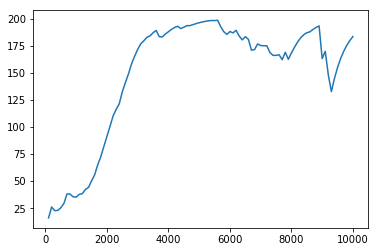

In [16]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda t: t[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [ ]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

## Homework part I (5+ pts)

Train a neural network for [`LunarLander-v2`](https://gym.openai.com/envs/LunarLander-v2).
* Getting average reward of at least +0 gets you 5 points
* Higher reward = more points


## Bonus I
* Try getting the same [or better] results on Acrobot __(+2 pts)__ or __LunarLander (+3 pts)__ using on-policy methods
* You can get n-step q-learning by messing with ```n_steps``` param in the q-learning code above
* Note that using large experience replay buffer will slow down on-policy algorithms to almost zero, so it's probably a good idea to use small experience replay buffer with several parallel agents